<a href="https://colab.research.google.com/github/lacykaltgr/continual-learning-ait/blob/main/notebooks/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''Download the files '''
'''Only for colab'''

!wget https://github.com/lacykaltgr/continual-learning-ait/archive/refs/heads/main.zip
!unzip main.zip
!find continual-learning-ait-main -type f ! -name "main.ipynb" -exec cp {} . \;

--2023-05-12 18:40:37--  https://github.com/lacykaltgr/continual-learning-ait/archive/refs/heads/main.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/lacykaltgr/continual-learning-ait/zip/refs/heads/main [following]
--2023-05-12 18:40:37--  https://codeload.github.com/lacykaltgr/continual-learning-ait/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [ <=>                ]   1.58M  --.-KB/s    in 0.1s    

2023-05-12 18:40:38 (12.6 MB/s) - ‘main.zip’ saved [1659385]

Archive:  main.zip
4dff863f426aaad61ea6374ee5bf27462c224ada
   creating: continual-learning-ait-ma

In [2]:
import tensorflow as tf
import keras

from data_preparation import load_dataset, CLDataLoader
from keras.callbacks import EarlyStopping
from keras import layers
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, BatchNormalization, GroupNormalization, UpSampling2D, ZeroPadding2D, Activation, Conv2DTranspose, Cropping2D

In [3]:
def load_cifar_10():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
    n_classes = 10
    X_train = (X_train / 127.5) -1
    X_test = (X_test / 127.5) -1
    y_train = tf.keras.utils.to_categorical(y_train, n_classes)
    y_test = tf.keras.utils.to_categorical(y_test, n_classes)
    return (X_train, y_train), (X_test, y_test)

In [ ]:
dpt_train, dpt_test = load_dataset('cifar-10', n_classes_first_task=4, n_classes_other_task=3)
batch_size = 512
train_loader = CLDataLoader(dpt_train, batch_size , train=True)
test_loader = CLDataLoader(dpt_test, batch_size, train=False)
INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)

170498071/170498071 [==============================] - 9s 0us/step


#Encoder

In [49]:
class Encoder(keras.Sequential):
    def __init__(self, KERNEL_SIZE = (3, 3), INPUT_SHAPE = (32, 32, 3)):
        super().__init__([
            Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'),
            BatchNormalization(),
            MaxPool2D(pool_size=(2, 2)),
            Dropout(0.25),

            Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'),
            BatchNormalization(),
            MaxPool2D(pool_size=(2, 2)),
            Dropout(0.25),

            Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'),
            BatchNormalization(),
            MaxPool2D(pool_size=(2, 2)),
        ])

#Classifier

In [50]:
class Classifier(keras.Sequential):
    def __init__(self):
        super().__init__([
            GroupNormalization(groups = 16, epsilon=1e-5),
            Activation("swish"),
            ZeroPadding2D((1, 1)),
            Conv2D(16, 3, strides=(1, 1)),
            ZeroPadding2D((1, 1)),
            Conv2D(8, 1, strides=(1, 1))
            
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dropout(0.25),
            Dense(10, activation='softmax')
        ]
        )

#Decoder

In [51]:
class Decoder(keras.Sequential):
  def __init__(self, KERNEL_SIZE = (3, 3), OUTPUT_SHAPE = (32, 32, 3)):
    super().__init__([
      UpSampling2D((2, 2)),
      Conv2DTranspose(128, KERNEL_SIZE, activation='relu', padding='same'),
      BatchNormalization(),
      Conv2DTranspose(128, KERNEL_SIZE, activation='relu', padding='same'),
      BatchNormalization(),
      UpSampling2D((2, 2)),
      Conv2DTranspose(64, KERNEL_SIZE, activation='relu', padding='same'),
      BatchNormalization(),
      Conv2DTranspose(64, KERNEL_SIZE, activation='relu', padding='same'),
      BatchNormalization(),
      UpSampling2D((2, 2)),
      Conv2DTranspose(32, KERNEL_SIZE, activation='relu', padding='same'),
      BatchNormalization(),
      Conv2DTranspose(32, KERNEL_SIZE, activation='relu', padding='same'),
      BatchNormalization(),
      Conv2DTranspose(3, KERNEL_SIZE, activation='sigmoid', padding='same'),
      Cropping2D((8, 8)) # Add this line
])

In [79]:
encoder = Encoder()
decoder = Decoder()
classifier = Classifier()

In [80]:
input_image = keras.Input(shape=(32, 32, 3), name="image")
encoded = encoder(input_image)
decoded = decoder(encoded)
classified = classifier(encoded)

In [81]:
encoder_decoder = keras.Model(inputs = input_image, outputs = decoded)
encoder_decoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss='mse',
)

In [82]:
encoder_classifier = keras.Model(inputs = input_image, outputs = classified)
encoder_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [61]:
es1 = EarlyStopping(patience=1, monitor="val_loss")
es2 = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)

In [78]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import numpy as np

def schedule(epoch, lr):
    return lr * 0.8

initial_lr = 0.05
optimizer = SGD(learning_rate=initial_lr)
encoder_decoder.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

lr_scheduler = LearningRateScheduler(schedule)

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def disp(image):
    image = (image + 1)* 127.5

    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    plt.show()

In [27]:
(X_train, y_train), (X_test, y_test) = load_cifar_10()

In [83]:
encoder_decoder.fit(X_train, X_train, batch_size=256, epochs=100, validation_data=(X_test, X_test), callbacks=[es2])

Epoch 1/100
196/196 [==============================] - 34s 164ms/step - loss: 0.2009 - val_loss: 0.2012
Epoch 2/100
196/196 [==============================] - 30s 155ms/step - loss: 0.1722 - val_loss: 0.1776
Epoch 3/100
196/196 [==============================] - 30s 155ms/step - loss: 0.1641 - val_loss: 0.1627
Epoch 4/100
196/196 [==============================] - 31s 156ms/step - loss: 0.1603 - val_loss: 0.1628
Epoch 5/100
196/196 [==============================] - 31s 156ms/step - loss: 0.1589 - val_loss: 0.1563
Epoch 6/100
196/196 [==============================] - 30s 155ms/step - loss: 0.1577 - val_loss: 0.1535
Epoch 7/100
196/196 [==============================] - 30s 156ms/step - loss: 0.1565 - val_loss: 0.1585
Epoch 8/100
196/196 [==============================] - 31s 156ms/step - loss: 0.1561 - val_loss: 0.1518
Epoch 9/100
 44/196 [=====>........................] - ETA: 22s - loss: 0.1560

KeyboardInterrupt: ignored

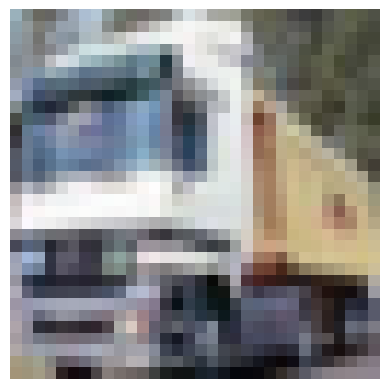

In [84]:
disp(X_train[1])

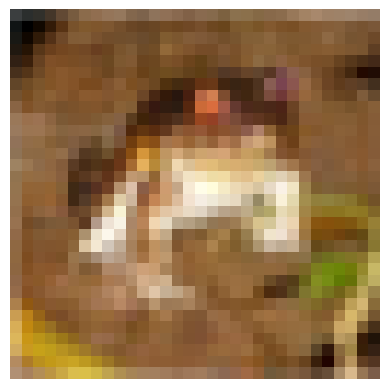

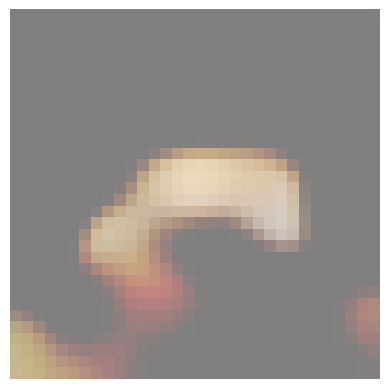

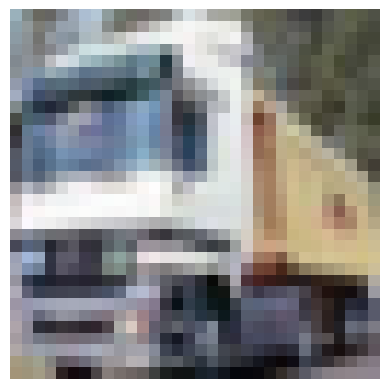

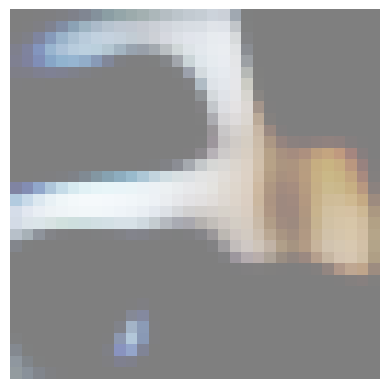

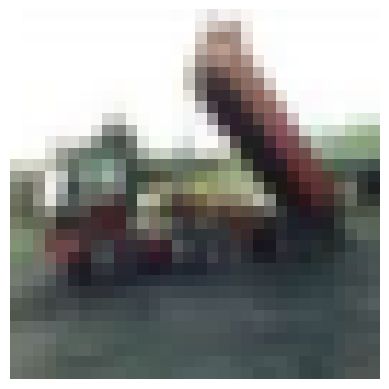

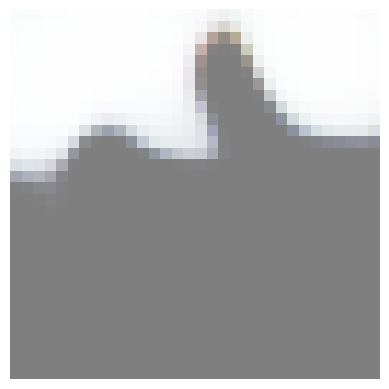

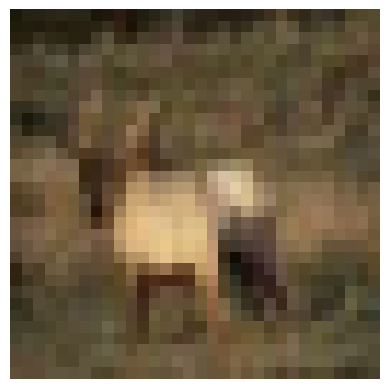

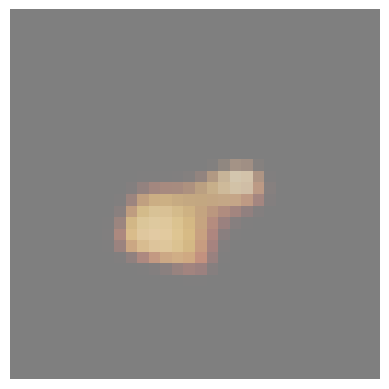

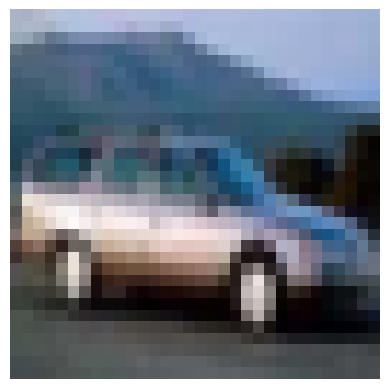

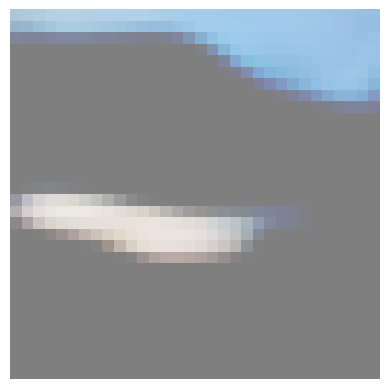

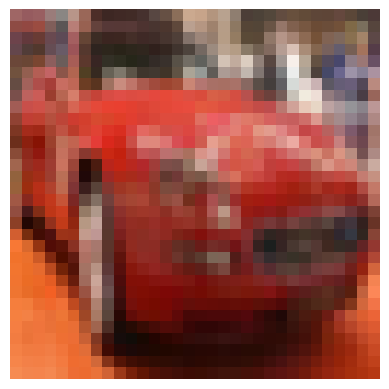

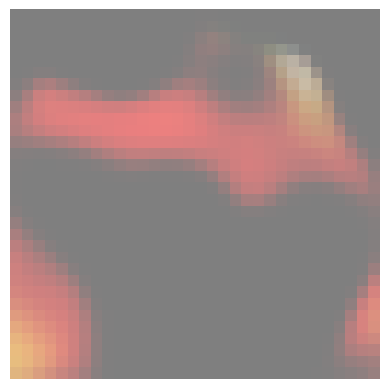

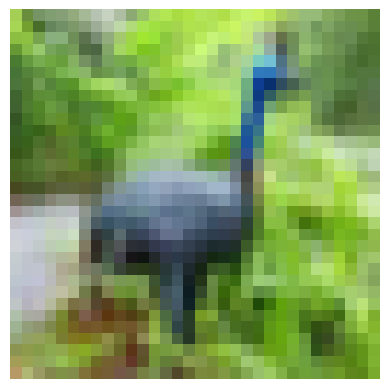

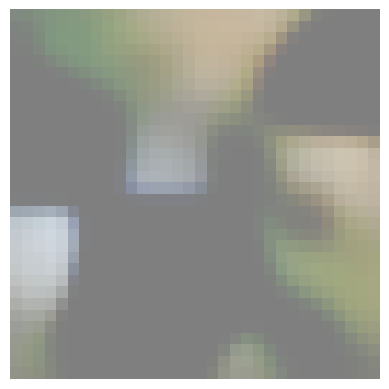

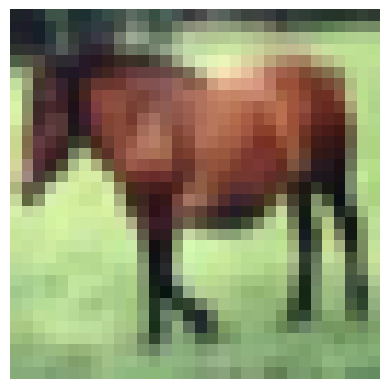

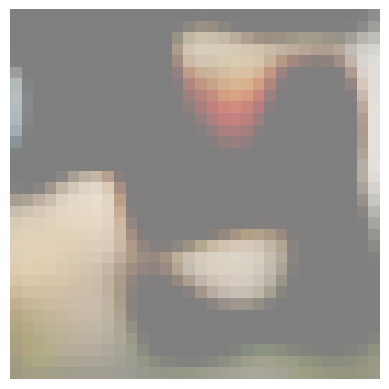

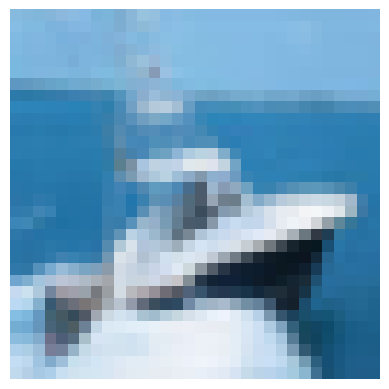

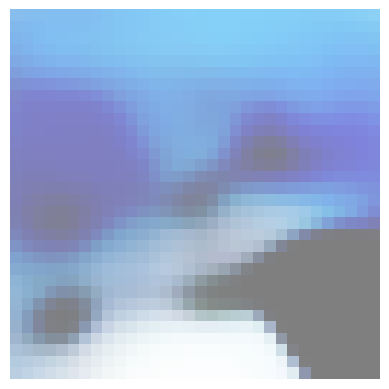

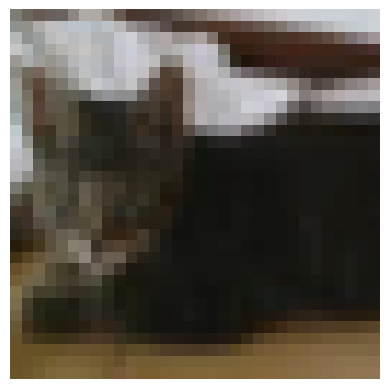

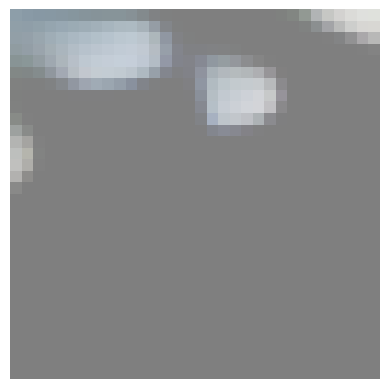

In [87]:
for i in range(10):
  disp(X_train[i])
  image = tf.expand_dims(X_train[i], axis=0)
  recon = encoder_decoder(image)
  disp(recon[0].numpy())

#Training

In [ ]:
prev_test = None
for (tr_loader, ts_loader) in zip(train_loader, test_loader):
  for epoch in range(5):
    for ((data, target) ,(testdata, testtarget)) in zip(tr_loader, ts_loader):
      encoder_classifier.fit(data, target, epochs=1, validation_data=(testdata, testtarget), callbacks=[es2])
  if (prev_test is not None):
    for (testdata, testtarget) in prev_test:
        encoder_classifier.evaluate(testdata, testtarget)
  prev_test = ts_loader
  print('\n\nNew Task')

5/5 [==============================] - 0s 21ms/step - loss: 0.3012 - accuracy: 0.8816 - val_loss: 0.2849 - val_accuracy: 0.8750


New Task
2/2 [==============================] - 0s 8ms/step - loss: 17.5139 - accuracy: 0.0000e+00


New Task
1/1 [==============================] - 0s 23ms/step - loss: 28.2109 - accuracy: 0.0000e+00


New Task


#Export the model

In [48]:
encoder_classifier.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[es2])

Epoch 1/100
1563/1563 [==============================] - 15s 9ms/step - loss: 2.1300 - accuracy: 0.1660 - val_loss: 1.9955 - val_accuracy: 0.1783
Epoch 2/100
1563/1563 [==============================] - 13s 8ms/step - loss: 1.9732 - accuracy: 0.2148 - val_loss: 1.8194 - val_accuracy: 0.2541
Epoch 3/100
1563/1563 [==============================] - 13s 8ms/step - loss: 1.8977 - accuracy: 0.2355 - val_loss: 1.9102 - val_accuracy: 0.2394
Epoch 4/100
1563/1563 [==============================] - 13s 9ms/step - loss: 1.8673 - accuracy: 0.2446 - val_loss: 1.8686 - val_accuracy: 0.2235
Epoch 5/100
1563/1563 [==============================] - 13s 8ms/step - loss: 1.9324 - accuracy: 0.2306 - val_loss: 2.3051 - val_accuracy: 0.1000
Epoch 6/100
1563/1563 [==============================] - 13s 8ms/step - loss: 2.3039 - accuracy: 0.0975 - val_loss: 2.3039 - val_accuracy: 0.1000
Epoch 7/100
1563/1563 [==============================] - 13s 8ms/step - loss: 2.3039 - accuracy: 0.0980 - val_loss: 2.3034 -

In [ ]:
encoder.save("encoder.h5")
classifier.save("classifier.h5")